# Generative adversarial networks (GAN)

Last time we got acquainted with autoencoders, including the possibility to use them as generators of new objects: by training an autoencoder we can take random vectors from the latent space learnt by it and feed them to the decoder and get objects similar to the ones we ‘learnt’.

In this way we can evaluate the properties of the latent space learnt by the encoder, perform smooth interpolation between objects, perform style transfer operations in the latent space, and much more.



<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/encoders_segment/encoder_as_generator.png" alt="Drawing" width= "800px;"/>



But there is one problem: **VAE are complex**.

For real tasks it can be very difficult to find the right lasso, components of lasso may conflict with each other....

We don't always need the representation of objects, often the problem is just to **generate** objects similar to our dataset. It turns out that it can be solved more efficiently by another scheme!


## The generation problem

We have unlabelled data, and we want to generate new data that will satisfy the following conditions:
* The new data should be similar to the original data.
* But not repeat them exactly (or repeat them, at random).
* So that the result of the generation will be different for different runs, we need an element of randomness.

Since we don't need an explicit encoder now, shall we abandon it in principle? Let's just sample random noise from a space of some given dimensionality (we'll call it **input** latent space by analogy with autoencoders) and feed it to the analogue of decoder - generator. By supplying noise rather than something meaningful to the input, we guarantee the required element of randomness.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/rnn/random_example.png" alt="Drawing" width= "400px;"/>

How to choose the dimensionality and shape of the input vector?

Small dimensionality of the input latent space (for example, one number with dimensionality 1) gives us a small volume of possible states and generation will be monotonous. On the other hand, by increasing the dimensionality of the latent space we can expand it so much that when training the model the points in this latent space will be so few that the space will consist of voids. Then the model will be extremely poor at ‘understanding’ what it needs to generate at a point that was not in the training sample.

The best way to choose a vector length is to look up a similar problem in publications, take a similar dimensionality, and start experimenting with the dimensionality from that starting point.

The same is true for choosing the shape of the input latent space, but in general choosing a multivariate nomal distribution in theory will be better accepted by the model weights and increase convergence.

## The naive approach and its problems

Let's take a very simple example: let's try to create a generator of points on a parabola.
It should be noted at once that this example is **so-so** -- we already know exactly the rule that generates the parabola, there is no point in using neural networks to find it! In real-world problems, however, we *exactly* don't know what rule our objects are arranged by, and we won't be able to penalise our model at all for generating something wrong. However, this example is quite illustrative, and, as we will see further on, we can show that such a scheme does not work without modifications. So let's take all the assumptions and see what we get.

Let us feed a random noise, say of size 3, to the input of the network. At the output we will expect parabola points. Let's check how it will work.


In [ ]:
import os
import numpy as np
import math
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from IPython.display import clear_output
from PIL import Image

import torch
import torch.nn as nn
from torch import autograd
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torchvision.utils import save_image

device = "cuda"

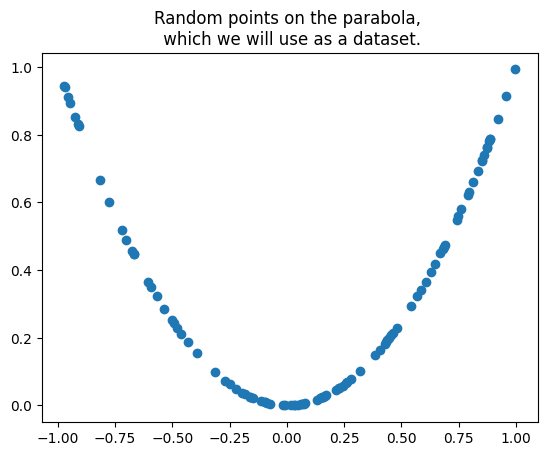

In [ ]:
def gen_pair(num=100):
    x = np.random.uniform(low=-1, high=1, size=(num,))
    y = x*x
    return np.hstack((x.reshape(-1,1), y.reshape(-1,1)))

pairs = gen_pair(100)
plt.scatter(pairs[:,0], pairs[:,1])
plt.title("Random points on the parabola, \n which we will use as a dataset.")
plt.show()

We take the dimensionality of the input latent space ls=3 and merge the noise with points into datasets.

In [ ]:
n_batches = 10
batch_size = 128
ls = 3 # latent space

noise = np.random.normal(size=(n_batches*batch_size, ls))
noise = torch.tensor(noise, dtype=torch.float)
print(f"NN Input: noise.shape: {noise.shape}")

xy_pair = gen_pair(num = n_batches*batch_size)
xy_pair = torch.tensor(xy_pair, dtype=torch.float)
print(f"NN Output: xy_pair.shape: {xy_pair.shape}")

dataset = TensorDataset(noise, xy_pair) # model inputs, model outputs

len_tr = int(len(dataset)*0.8)
len_tst = len(dataset) - len_tr
trainset, testset = random_split(dataset,[len_tr,len_tst])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

NN Input: noise.shape: torch.Size([1280, 3])
NN Output: xy_pair.shape: torch.Size([1280, 2])


In [ ]:
def get_test_loss(model,test_loader,loss_function):
    with torch.no_grad():
        loss_test_total = 0
        for samples, labels in test_loader:
            outputs = model(samples.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss_test_total += loss.item()
        return loss_test_total/len(test_loader)

Let's define a simple model that will expect noise on the input, and generate points on the output. (Note that there is no activation function on the last layer, since we do not limit our generator in any range.)

In [ ]:
class GenModel(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50,2))

    def forward(self, x):
        return self.model(x)

In [ ]:
epochs = 300
model = GenModel(latent_space = ls)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.L1Loss().to(device)

for epoch in range(epochs):
    loss_epoch = 0
    for samples, labels in train_loader:
        #print(samples.shape)
        optimizer.zero_grad()
        outputs = model(samples.to(device))
        loss = loss_function(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()

    loss_test = get_test_loss(model,test_loader,loss_function)
    if epoch%100==0:
        print(f"Epoch={epoch} train_loss={loss_epoch/len(train_loader):.4} test_loss={loss_test:.4}")


Epoch=0 train_loss=0.4043 test_loss=0.3908
Epoch=100 train_loss=0.3488 test_loss=0.3883
Epoch=200 train_loss=0.3332 test_loss=0.3942


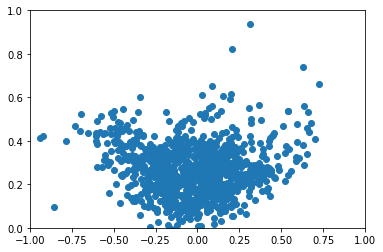

In [ ]:
def test_image(model, ls = 3):
    model.cpu()
    noice = torch.tensor(np.random.normal(size=(1000, ls)), dtype=torch.float)
    xy_pair_gen = model(noice)

    xy_pair_gen = xy_pair_gen.detach().numpy()
    plt.scatter(xy_pair_gen[:,0], xy_pair_gen[:,1])
    plt.axis([-1, 1, 0, 1])
    plt.show()
    model.to(device)
test_image(model)

The training failed.

As you can see, the results are really bad. The model clearly does not understand that points should not exist outside the parabola. We need to figure out how to make the points ‘push’ from the region where the parabola does not exist.

L1 loss doesn't work. Perhaps we need to be more strict and just penalise any points that are strictly outside the parabola?

Epoch=0 train_loss=0.04525 test_loss=0.03087


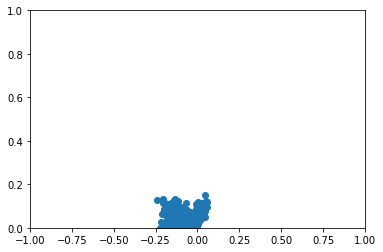

Epoch=50 train_loss=0.001697 test_loss=0.002202


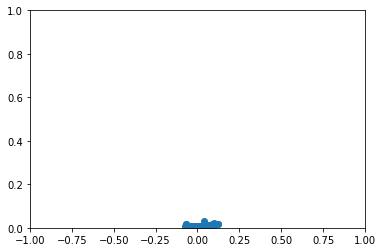

Epoch=100 train_loss=0.001502 test_loss=0.001708


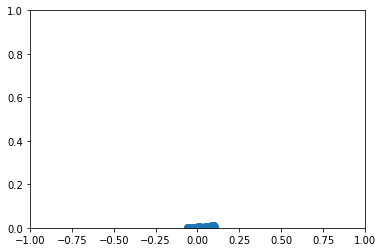

Epoch=150 train_loss=0.001252 test_loss=0.001386


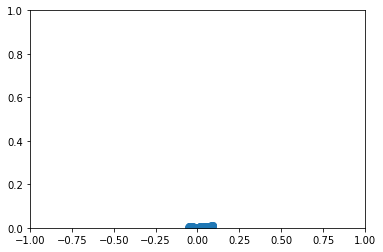

Epoch=200 train_loss=0.0009492 test_loss=0.001261


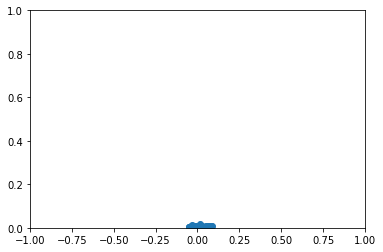

Epoch=250 train_loss=0.000812 test_loss=0.001144


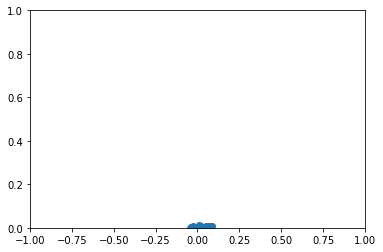

In [ ]:
def custom_losss(pair,label):
  # All inputs are batches
  x_fake = pair[:,0]
  y_fake = pair[:,1]
  return torch.abs(x_fake*x_fake - y_fake).mean() # average by batch

epochs = 300
model = GenModel(latent_space = ls)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#loss_function = nn.L1Loss().to(device)
loss_function = custom_losss

for epoch in range(epochs):
    loss_epoch = 0
    for samples, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(samples.to(device))
        loss = loss_function(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()

    loss_test = get_test_loss(model,test_loader,loss_function)
    if epoch%50==0:
        print(f"Epoch={epoch} train_loss={loss_epoch/len(train_loader):.4} test_loss={loss_test:.4}")
        test_image(model)

It failed again! Recall the previous lecture: neural networks like to be cunning and take the path of least resistance. In this case, it is most convenient for it to find a convenient point at which it is guaranteed to hit the target (for example, 0) and generate objects in a small area around it. Failure.

## Discriminator

Let's try to come at it from the other side. We need to penalise our model for generating ‘incorrect’ objects. The usual L1 loss does not work in this case. A strict penalty for not matching the ‘correct’ rule didn't work either. And this is despite the fact that we knew exactly which objects would be right and which would be wrong! In real life, the situation is even more complicated.  We need some other approach, ideally one that independently identifies patterns of ‘correct’ objects and adaptively tightens the penalty as the model is trained.

We can define a second model that will determine whether points lie on a parabola or not. Let us call such a model **discriminator**, or critic.

In [ ]:
class DisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 25),
            nn.ReLU(),
            nn.Linear(25, 15),
            nn.ReLU(),
            nn.Linear(15,1),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

In total, we have: a generator that produces points either hitting the parabola or not hitting it. And also a discriminator, which will learn to distinguish them. Therefore, we will feed the generator with synthetic correct points, considering them real, and the points that the generator produces, considering them fake.

Thus, the generator will learn to imitate real data, and the discriminator will learn to distinguish real points from fake ones.

We have come to the idea of generative and adversarial neural networks.

##  Generative adversarial network (GAN)

The generative-adversarial network was described by Google's Ian Goodfellow in 2014.

Let us call our counterfeiter $G$ (or generator) and our banker $D$ (or discriminator). We have some amount of original money $X$ for the banker, and let his output be a number ranging from zero to one, so that it expresses the banker's confidence that the money given to him for consideration is real. More - since the counterfeiter is a neural network, it needs some input data, let's call it $z$ - this is our random noise that the model will try to turn into money.


Then, obviously, the goal of the counterfeiter is to maximise $D(G(z))$, that is, to make the banker sure that the forgeries are real.

The banker's goal is more complicated - he needs to simultaneously positively identify the originals, and negatively identify the forgeries. Let us write this as maximising $D(x)(1-D(G(z)))$. Multiplication can be turned into addition by taking the logarithm, so we get:

For the banker: maximise $log(D(X))+log(1-D(G(z)))$

For the counterfeiter: maximise $log(D(G(z)))$

![minmax loss](https://theaisummer.com/static/16451c8109d2540415babbfd245fe0cc/d80c4/gan_training.jpg)

We know that the discriminator maximises this function with respect to its parameters $\theta_d$, where given a fixed generator ${G}_{\theta_{g}}$, it performs binary classification: it assigns a probability of 1 to data points from the training set $E_{x∼p_{data}}$ and assigns a probability of 0 to the generated samples $E_{z∼p(z)}$

Since an approach from game theory is used, our loess function is represented as a minimax function. The discriminator tries to maximise the target function, so we can perform a gradient lift of the target function. The generator tries to minimise the target function, so we can perform a gradient descent for the target function. By alternating between gradient ascent and descent, the network can be trained.


<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/rnn/gan_scheme.png" alt="Drawing" width= "800px;"/>

In the process of joint competitive learning, if the system is sufficiently balanced, a minimax equilibrium state is reached in which both networks have significantly improved their quality, and now the generated images can be used almost as real ones.

If, however, we first train the discriminator (make it a ‘strong critic’), the generator simply cannot be trained.

**GAN Advantages**
* Theoretical guarantees of convergence (it is shown that GANs' loess provides correct generation if the parameters are *correctly* chosen)
* Solves explicitly the problem of generative modelling

**Disadvantages of GAN**
* Unstable learning
* Very long convergence time
* Mode-collapsing
* Generator starvation
**Finding optimal parameters - **pure luck**

https://developers.google.com/machine-learning/gan/problems

https://developers.google.com/machine-learning/gan/loss

### GAN: correcting a naive approach

Let's create two functions that return batches:

The first function will create a random vector to the generator input and the class labels will be units, because we want the generator to give such points that the classifier recognises them as units (correct). So the loss function will adjust the generator weights to units.

In [ ]:
def get_g_batch(batch_size, latent_dim):
    g_input = torch.randn(size=(batch_size, latent_dim)).to(device)
    labels = torch.ones(size=(batch_size,)).to(device)
    return g_input, labels

The second function will give a batch to the input of the discriminator by mixing:

* True points on the parabola (to train the discriminator)
* Points not on the parabola (so that the discriminator knows where the ‘not parabola’ is)
* Generator output as wrong (so that the generator does not collapse to one true point)

In [ ]:
def get_mix_batch(batch_size, latent_dim, netG):
    types_of_points = []

    # Generate true pairs and true labels
    if True:
        x = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        true_pair = torch.vstack((x, x*x)).T.to(device)
        true_labels = torch.ones(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((true_pair, true_labels)))

    # Generate fake uniform pairs and fake labels
    # disable this to get Mode-collapsing
    if False:
        x_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        y_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        fake_pair = torch.vstack((x_fake, y_fake)).T
        fake_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((fake_pair, fake_labels)))

    # Generate points from generator and set labels as fake
    if True:
        gan_pair = netG(torch.randn(size=(batch_size, latent_dim)).to(device))
        gan_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((gan_pair, gan_labels)))

    # Stack all types of points
    z = torch.vstack(types_of_points)
    # Shuffle
    z=z[torch.randperm(z.size()[0])]

    # Split back to samples and labels
    mixed_pairs = z[:, :2]
    mixed_labels = z[:, 2]
    return mixed_pairs, mixed_labels

For convenience, let's wrap the backpropagation steps of the discriminator and generator in functions

In [ ]:
def netD_step(netD, batchD, loss_func, optimizer):
    samples, labels = batchD
    optimizer.zero_grad()
    outputs = netD(samples.to(device))
    loss = loss_func(outputs.to(device), labels.unsqueeze(1).detach().to(device))
    loss.backward()
    optimizer.step()

In [ ]:
def netG_step(netD, netG, batchG, loss_func, optimizer):
    samples, labels = batchG
    optimizer.zero_grad()
    outputs = netD(netG(samples.to(device)))
    loss = loss_func(outputs.to(device), labels.unsqueeze(1).detach().to(device))
    loss.backward()
    optimizer.step()

Each epoch will display what the generator is already able to generate

In [ ]:
def plot_gen(netG, epoch="Not provided"):
    Gin, _ = get_g_batch(1000, latent_dim)
    out = netG(Gin).cpu()
    plt.scatter(out.detach().numpy()[:, 0], out.detach().numpy()[:, 1], color="blue", s=1)
    plt.title(f'Generator points. End of epoch= {epoch+1}', fontsize=10)
    plt.axis([-1,1,-0.5,1])
    plt.show()


Since the networks are trained one by one, we will create two optimisers.

(Note: in the case of VAE, even when we had separate networks for encoder and decoder, we trained them together and used one optimiser).

In [ ]:
latent_dim = 5
batch_size = 512
batch_per_epoch = 1000
epochs = 10

netG = GenModel(latent_dim).to(device)
netD = DisModel().to(device)
loss_func = nn.BCELoss().to(device)
optD = torch.optim.Adam(netD.parameters(), lr=0.001)
optG = torch.optim.Adam(netG.parameters(), lr=0.001)

The training cycle will create a data batch (batch_size) for the generator, and a batches from a mixture of points (3*batch_size) for the discriminator. The balance of data fed to both networks can be experimented with.

In [ ]:
def train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG):
    for epoch in range(epochs):
        for _ in range(batch_per_epoch):
            batchG = get_g_batch(batch_size, latent_dim)
            batchD = get_mix_batch(batch_size, latent_dim, netG)

            netD.train(True)
            netG.train(False)
            netD_step(netD, batchD, loss_func, optD)

            netD.train(False)
            netG.train(True)
            netG_step(netD, netG, batchG, loss_func, optG)

        # clear_output()
        plot_gen(netG, epoch)

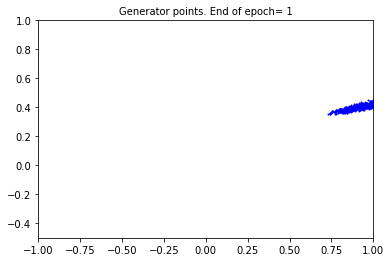

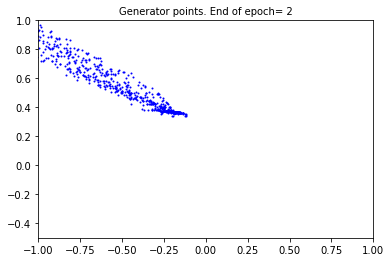

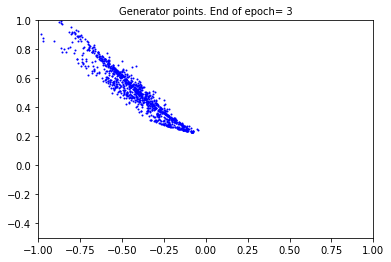

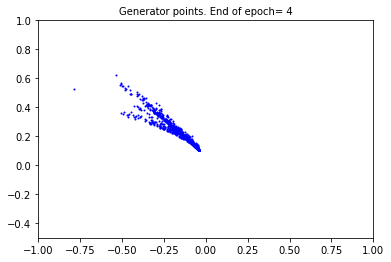

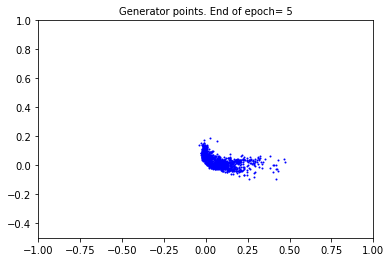

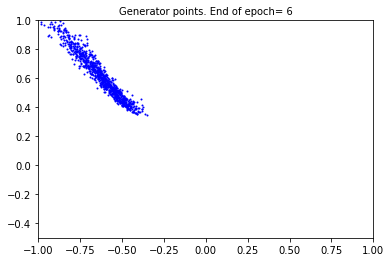

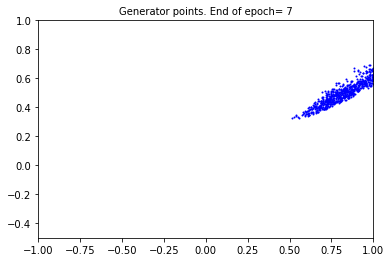

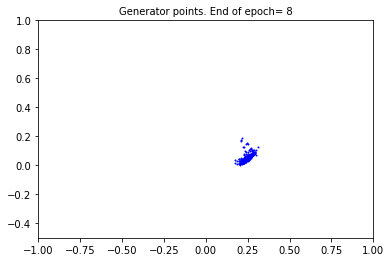

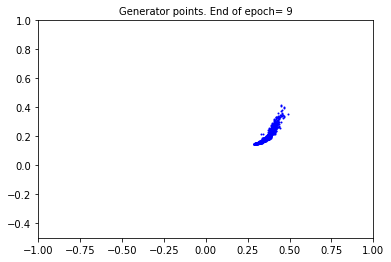

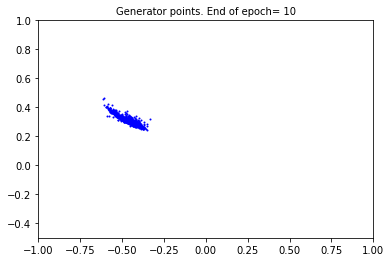

In [ ]:
train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG)

The network is perfectly trained when all types of points are fed to the discriminator. You can disable some types and see what happens.

## DCGAN - Image generation

With GAN you can, of course, generate not only points on a parabola. You can generate images, for example.

For this purpose, we can again use the expanding convolution blocks -- Upsample and ConvTranspose2d.



<img src="https://wiki.pathmind.com/images/wiki/GANs.png" alt="Drawing" width= "900px;"/>

## cGAN - GAN with condition

When studying autoencoders, we paid special attention to cVAEs -- conditioned autoencoders. By feeding the label directly to the decoder, we helped our network avoid wasting effort and weight on separating objects of different classes in latent space, and as a result, it was able to learn a separate representation for each class that takes into account only the variant scatter of objects in that class. This allowed us to use the trained autoencoder for style transfer tasks, saving us the trouble of distinguishing between classes that are too close, etc.

We can apply a similar scheme with class labels transfer in the case of generative-adversarial networks. The condition can be anything, for example, generation of a particular digit. Of course, in this case we will need an already labelled dataset to train the discriminator.


<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/rnn/cgan_scheme.png" alt="Drawing" width= "800px;"/>

The catch in this case is the class label or label, which is labelled Y in the figure. The label is added to the random noise, thus we tell the generator to generate a random image of the desired class. It is also fed to the discriminator as an input so that the discriminator knows which image to classify as real and which as fictitious.






### Text to image

We can feed the model input and not random noise, but some description of the object we want to get (for example, a vector of specified properties: Object Class, Angles and Rotations, Specified Transformation Parameters, Segmentation).

The description can be in the form of natural text.  The goal is to generate images from text, and to allow the user to manipulate synthetic images using natural language descriptions in a single structure.


Text-to-image network architectures transform the input text into embeddings using RNN or Transformer blocks as input, then feed a generator/discriminator or ensemble of such models. One example in PyTorch -- **ControlGAN** .

<a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8641270">paper</a>


<a href="https://github.com/mrlibw/ControlGAN">Github</a>



<img src="https://github.com/mrlibw/ControlGAN/raw/master/archi.jpg" alt="Drawing" width= "900px;"/>



In November 2021, NVIDIA <a href="https://blogs.nvidia.com/blog/2021/11/22/gaugan2-ai-art-demo/">has shown</a> GauGAN2 -- modification of one of its previous developments, allowing to generate photorealistic images by text description. By the way, you can try the model in practice <a href="https://www.nvidia.com/en-us/research/ai-demos/">here</a>.

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/rnn/gaugan_output.jpg" alt="Drawing" width= "600px;"/>



It is worth noting that not all Text-to-image models are inherently GAN: for example, the widely known <a href="https://openai.com/blog/dall-e">DALL·E</a> от OpenAI

<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/rnn/dalle.png" alt="Drawing" width= "700px;"/>

## Drug designs.

In biology, we do not need to generate pictures very often. The idea of generating structures of various substances (in particular, small molecules) is much more relevant. This can be done in different ways for different tasks, a lot depends on the data representation and the problem to be solved. The success of architectures based on graph layers (we will talk about them at the end of our course) is worth mentioning separately.

A good and clear example of a small molecule generator based on graph convolutions and Wasserstein's Loss:

https://keras.io/examples/generative/wgan-graphs/


<a href="https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/wgan-graphs.ipynb">Colab</a>




<img src="https://kodomo.fbb.msu.ru/FBB/year_20/ml/rnn/wgan_gp.png" alt="Drawing" width= "600px;"/>

The example is obviously toyish, but generating substances with **defined properties** for **defined protein** is a huge hype and many articles are being done on it. For example -- <a href="https://www.nature.com/articles/s41587-019-0224-x
">paper</a> Insilico Medicine on the generation of DDR1 kinase inhibitors using a reinforcement learning approach.

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41587-019-0224-x/MediaObjects/41587_2019_224_Fig1_HTML.png?as=webp" alt="Drawing" width= "800px;"/>






## GAN modifications

The number of variations of GAN has been enormous. It would take no time at all to list them all, for example, there is a noticeable growth of new solutions for recognition or segmentation using GAN ideas. You can read more, for example <a href="https://paperswithcode.com/methods/category/generative-models">here</a>.

A few variations that I would like to mention:

* **EBGAN** (Energy-based Generative Adversarial Network) treats the discriminator as a function of energy, which assigns low energies to regions near the region corresponding to our data, and higher energies to other regions, similar to probabilistic models. Thus, we would expect the generator to create objects with minimal ‘energy’ values.

* **InfoGAN**: we don't feed label into the discriminator, but expect it to classify according to the class we want to get from the generator.

* **AC-GAN** (auxiliary classifier): the difference is that the discriminator has to classify real and fake images in addition to recognising them. It has the effect of stabilising the learning process and allows us to generate large high quality images by learning a representation in the latent space that does not depend on the class label.

<img src="https://raw.githubusercontent.com/hussain7/tensorflow-generative-model-collections/master/assets/etc/GAN_structure.png" alt="Drawing" width= "800px;"/>

<a href="https://giters.com/hussain7/tensorflow-generative-model-collections">Source</a>

##  AAE

It turns out that GAN and VAE can be ‘crossed’. Such neural networks are called **adversarial autoencoders**. In the case of VAE, we needed to require the generated multivariate distribution to be close to normal, so that the encoder could not ‘cheat’ and null the vectors of generated standard deviations, thus reducing the resulting distributions to single points. For this purpose, we used KL-divergence as the second component of the loess, which required the resulting vectors in the latent space to be close to those drawn from the normal distribution. This approach has many problems, including the KL-divergence itself is not ideal. We can try to replace it with a discriminator -- now it will distinguish the latent representation we generated from the standard normal distribution. If it can discriminate well, we penalise the encoder for this.



Suddenly, this saves us from even having to do any additional manipulation with the encoder - we don't need it now to output the mean and variance, and then we use them to generate objects from the real distribution. It is enough for us that the discriminator cannot distinguish the latent representation we get from the normal distribution.

Moreover, it turns out that AAE can generate more ‘high-quality’ objects than vanilla VAE. It can be shown theoretically that this is a consequence of the fact that it minimises not the KL-divergence, but the more efficient Jensen-Shannon divergence. However, a detailed discussion of this is beyond the scope of the course.

Also, it is easier for AAE to get your latent representation to look specific. Simply generate a sample from the desired (not necessarily normal!) distribution and tell the discriminator to try to distinguish the generated sample from objects in the latent representation.

<img src="https://miro.medium.com/max/875/1*pRwUVN0764BOJpgGXS50jg.png" alt="AAE pic 2" width= "700px;"/>



Another article from Insilico about generating new chemicals, this time using AAUs -- [druGAN](https://pubs.acs.org/doi/10.1021/acs.molpharmaceut.7b00346).

<img src="https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/mpohbp/2017/mpohbp.2017.14.issue-9/acs.molpharmaceut.7b00346/20170829/images/medium/mp-2017-00346k_0007.gif" alt="AAE pic 3" width= "800px;"/>



